In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io
import pandas as pd
import numpy as np
import mne

# 1. Data Loading


In [2]:
# read EEG .mat file and load
mat_file_path = './data/sp1s_aa_1000Hz.mat'
mat_data = scipy.io.loadmat(mat_file_path)

In [3]:
# Access EEG train feature data from the loaded .mat file
train_X = mat_data['x_train']
train_X.shape # time * channel * trials

(500, 28, 316)

In [4]:
# Access EEG test data from the loaded .mat file
test_X = mat_data['x_test']
test_X.shape # time * channel * trials

(500, 28, 100)

In [5]:
# Access EEG train label data from the loaded .mat file
train_y = mat_data['y_train']
train_y.shape # time * channel * trials

(1, 316)

# 2. Data Preprocessing


In [6]:
from utils.multi_raw import set_multiple_raw
from utils.fileIO import save_preprocessed_data, load_preprocessed_data

In [7]:
channel_names = ['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']

In [8]:
# sample_rate = 1000
# # Create raws of all trials
# train_X_raws = set_multiple_raw(train_X, channel_names, sample_rate)

In [9]:
# from preprocessing.preprocess import EEGPreProcessor

# # Create an instance of EEGPreprocessor
# preprocessor = EEGPreProcessor(train_X_raws)

# b_freq = [0.01, 50.]
# s_freq = 500
# p_freq = 50

# # Perform preprocessing steps
# preprocessed_data = preprocessor.preprocess(b_freq, s_freq, p_freq)

# save_path = './save/train_X_500Hz.csv'
# save_preprocessed_data(preprocessed_data, save_path)


In [10]:
# fig = preprocessed_data[1].plot(n_channels=len(channel_names), show=True, scalings='auto')
# fig = preprocessed_data[1].compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads", amplitude=False)

In [11]:
# temp = preprocessed_data[0].copy().filter(l_freq=b_freq[0], h_freq=50.)
# temp.info

In [12]:
# fig = temp.plot(n_channels=len(channel_names), show=True, scalings='auto')
# fig = temp.compute_psd(fmax=100).plot(average=True, picks="data", exclude="bads", amplitude=False)

In [13]:
# save_path = './save/train_X_500Hz.csv'
# save_preprocessed_data(preprocessed_data, save_path)

In [14]:
load_path = './save/train_X_500Hz.csv'
train_X_processed = load_preprocessed_data(load_path, len(channel_names))

In [15]:
train_y_processed = np.transpose(train_y)

In [16]:
print(f'Shape of X: {train_X_processed.shape} | Shape of y: {train_y_processed.shape}')

Shape of X: (316, 28, 250) | Shape of y: (316, 1)


In [17]:
n_trials = train_X_processed.shape[0]
n_channels = train_X_processed.shape[1]
n_features = train_X_processed.shape[2]
s_freq = 500 # Adjust the sampling rate according to loaded data
print("[Information of data, Please Check before processing]")
print(f'Trials: {n_trials}\nChannels: {n_channels}\nFeatures: {n_features}\nSampling Rate: {s_freq}Hz')


[Information of data, Please Check before processing]
Trials: 316
Channels: 28
Features: 250
Sampling Rate: 500Hz


# 3. Feature Extraction

In [18]:
from scipy import signal
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [19]:
from evaluation.evaluation_tools import evaluate_with_randomforest, evaluate_with_tsne

### Statistical Analysis

In [20]:
# A function to extract statistical features from each epoch
def statistical_features(epoch_data):
    features = []
    
    # Example: Mean, Standard Deviation, Skewness, and Kurtosis
    features.append(np.mean(epoch_data, axis=1))
    features.append(np.std(epoch_data, axis=1))
    features.append(stats.skew(epoch_data, axis=1))
    features.append(stats.kurtosis(epoch_data, axis=1))
    
    # Add more statistical features as needed
    return np.concatenate(features)

In [21]:
# Extract features for each epoch
statistical_feature_matrix = np.array([statistical_features(trial) for trial in train_X_processed])

In [22]:
statistical_feature_matrix.shape

(316, 112)

### Wavelet Transform Analysis

In [23]:
# Define the wavelet transform function
def wavelet_transform(data, scales):
    wavelet_features = []
    channels = data.shape[0]
    for channel in range(channels):
        for scale in scales:
            # Apply continuous wavelet transform (CWT)
            wavelet_data = signal.cwt(data[channel, :], signal.morlet, [scale])

            # Extract features (e.g., mean, variance) from the wavelet coefficients
            wavelet_features.append(np.mean(np.abs(wavelet_data)))
            wavelet_features.append(np.var(np.abs(wavelet_data)))

    return np.array(wavelet_features)

In [77]:
scales = np.arange(1, 2)  # Adjust the range of scales based on your requirements

# Extract wavelet transform features for each epoch
wavelet_feature_matrix = np.array([wavelet_transform(trial, scales) for trial in train_X_processed])


In [78]:
wavelet_feature_matrix.shape

(316, 56)

### Blind Source Separation Analysis

In [26]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from mne.decoding import CSP

In [27]:
# def find_optimal_component(c_min, c_max, bss=None, X=None, y=None):
#     # Find the optimal number of components
#     scores = []
#     components_range = range(c_min, c_max)  # Adjust the range as needed
#     # Reshape the data to (n_samples, n_features)
#     reshaped_data = X.reshape(X.shape[0], -1)

#     for n_components in components_range:
#         if bss == 'pca':
#             pca = PCA(n_components=n_components)
#             feature_matrix = pca.fit_transform(reshaped_data)

#         if bss == 'ica':
#             ica = FastICA(n_components=n_components, random_state=42)
#             feature_matrix = ica.fit_transform(reshaped_data)
    
#         if bss == 'svd':
#             svd = TruncatedSVD(n_components=n_components, random_state=42)
#             feature_matrix = svd.fit_transform(reshaped_data)

#         if bss == 'csp':
#             csp = CSP(n_components=n_components, reg=None, log=None, norm_trace=False)
#             feature_matrix = csp.fit_transform(X, train_y.reshape(-1))

#         X_train = feature_matrix
#         y_train = y

#         scores.append(evaluate_with_randomforest(X_train, y_train, str(n_components), show=False))
        
#     optimal_n_components = components_range[np.argmax(scores)]

#     return optimal_n_components

### Blind Source Separation
#### - PCA (Principal Component Analysis)

In [28]:
# Reshape the data to (n_samples, n_features)
reshaped_data = train_X_processed.reshape(train_X_processed.shape[0], -1)
reshaped_data.shape

(316, 7000)

In [29]:
# pca_components = find_optimal_component(30, 50, bss='pca', X=train_X_processed, y=train_y.T.reshape(-1))

In [30]:
# Initialize PCA model
pca = PCA(n_components=49)

# Transform the data using the learned PCA components
pca_feature_matrix = pca.fit_transform(reshaped_data)

pca_feature_matrix.shape

(316, 49)

### Blind Source Separation
#### - ICA (Independent Component Analysis)

In [31]:
# ica_components = find_optimal_component(30, 50, bss='ica', X=train_X_processed, y=train_y.T.reshape(-1))

In [32]:
ica = FastICA(n_components=3, random_state=42)

ica_feature_matrix = ica.fit_transform(reshaped_data)

ica_feature_matrix.shape

(316, 3)

### Blind Source Separation
#### - SVD (Singular Value Decomposition)

In [33]:
# svd_components = find_optimal_component(30, 50, bss='svd', X=train_X_processed, y=train_y.T.reshape(-1))

In [34]:
svd = TruncatedSVD(n_components=43, random_state=42)
svd_feature_matrix = svd.fit_transform(reshaped_data)
svd_feature_matrix.shape

(316, 43)

### Blind Source Separation
#### - CSP (Common Spatial Pattern)

In [35]:
# # Define and apply CSP
# csp_components = find_optimal_component(10, 50, bss='csp', X=train_X_processed, y=train_y.T.reshape(-1))

In [36]:
csp = CSP(n_components=20, reg=None, log=None, norm_trace=False)

csp_feature_matrix = csp.fit_transform(train_X_processed, train_y.reshape(-1))

Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 28 dim * 2.8e+16  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 28 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 28 -> 27
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 28 dim * 2.7e+16  max singular value)
    Estimated rank (mag): 27
    MAG: rank 27 computed from 28 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 28 -> 27
Estimating covariance using EMPIRICAL
Done.


In [37]:
print(csp_feature_matrix.shape)

(316, 20)


### PSD (Power Spectral Density) Analysis

In [38]:
# Function to compute PSD features for a single trial
def compute_psd_features(trial, freq_bands, sfreq=1000):
    psd_features = []
    for channel_data in trial:
        _, psd = signal.welch(channel_data, fs=sfreq, nperseg=len(channel_data))
        for f_band in freq_bands:
            band_psd = np.sum(psd[(f_band[0] <= _) & (_ <= f_band[1])])
            psd_features.append(band_psd)
    return psd_features

In [39]:
# Define the frequency bands of interest
freq_bands = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 40)] # Delta(0.5-4 Hz), Theta(4-8 Hz), Alpha(8-13 Hz), Beta(14-30 Hz), Gamma(30Hz -)

In [40]:
# Apply the PSD feature extraction to all trials
psd_feature_matrix = [compute_psd_features(trial, freq_bands, sfreq=s_freq) for trial in train_X_processed]

# Convert the list to a NumPy array
psd_feature_matrix = np.array(psd_feature_matrix)

In [41]:
psd_feature_matrix.shape

(316, 140)

### Event-Related Desynchronization/synchronization (ERD/ERS)

In [42]:
''' First try with mne multi raws'''
# from mne.time_frequency import psd_array_multitaper

# # sample_raws = set_multiple_raw(train_X_processed.T, channel_names=channel_names, sample_rate=s_freq)

# X_class_left_train = train_X_processed[train_y.reshape(-1) == 0]
# X_class_right_train = train_X_processed[train_y.reshape(-1) == 1]

# print(X_class_left_train.shape)
# print(X_class_right_train.shape)

# left_raws = set_multiple_raw(X_class_left_train.T, channel_names=channel_names, sample_rate=s_freq)
# right_raws = set_multiple_raw(X_class_right_train.T, channel_names=channel_names, sample_rate=s_freq)

# c3 = channel_names.index('C3')
# c4 = channel_names.index('C4')

# trial_to_plot = 10
# fig = left_raws[trial_to_plot].compute_psd(fmax=12, picks=[c3, c4]).plot(picks="data", exclude="bads", amplitude=False)
# fig.suptitle("{}".format('Left'), size="x-large", weight="bold")
# fig = right_raws[trial_to_plot].compute_psd(fmax=12, picks=[c3, c4]).plot(picks="data", exclude="bads", amplitude=False)
# fig.suptitle("{}".format('Right'), size="x-large", weight="bold")

' First try with mne multi raws'

In [43]:
X_class_left_train = train_X_processed[train_y.reshape(-1) == 0]
X_class_right_train = train_X_processed[train_y.reshape(-1) == 1]

c3 = channel_names.index('C3')
c4 = channel_names.index('C4')

In [44]:
# Create MNE info structure (assumption: 500 Hz sampling rate)
info = mne.create_info(ch_names=channel_names, sfreq=s_freq, ch_types=['eeg']*n_channels)
info.set_montage('standard_1020')

# Create an EpochsArray with your EEG data
epochs_array_0 = mne.EpochsArray(X_class_left_train, info, tmin=0)
epochs_array_1 = mne.EpochsArray(X_class_right_train, info, tmin=0)

Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
157 matching events found
No baseline correction applied
0 projection items activated


# 4. Evaluation with T-SNE

In [45]:
from evaluation.evaluation_tools import evaluate_feature

### Run with Original Data

In [46]:
train_X_original = np.transpose(np.concatenate(train_X, axis=0))
train_y_original = np.transpose(train_y)

[Result of t-SNE]


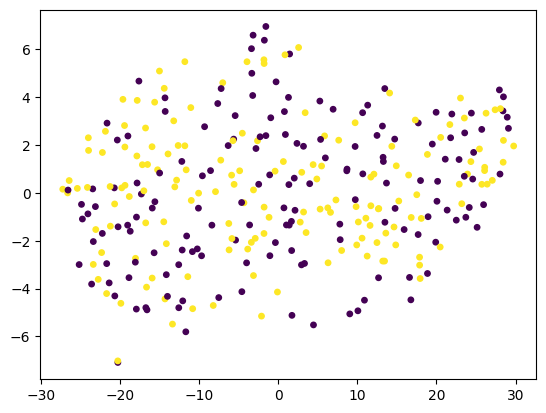

[Result of Random Forest]
Original Data Test Accuracy: 0.53


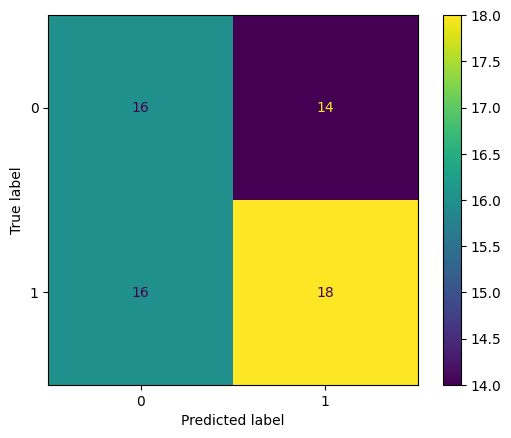

In [47]:
evaluate_feature(train_X_original, train_y_original, 'Original Data')

### Run with Statistical Feature

In [48]:
train_X_static = statistical_feature_matrix
train_y_static = np.transpose(train_y)

[Result of t-SNE]


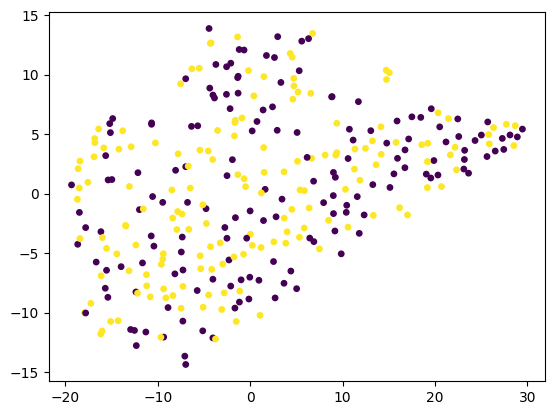

[Result of Random Forest]
Statistical Feature Test Accuracy: 0.62


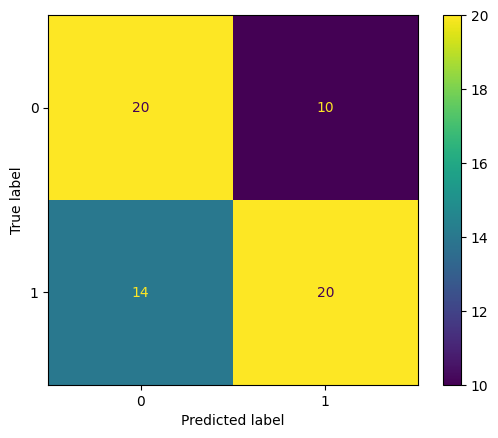

In [49]:
evaluate_feature(train_X_static, train_y_static, 'Statistical Feature')

### Run with Wavelet Transform


In [79]:
train_X_wav = wavelet_feature_matrix
train_y_wav = np.transpose(train_y)

[Result of t-SNE]


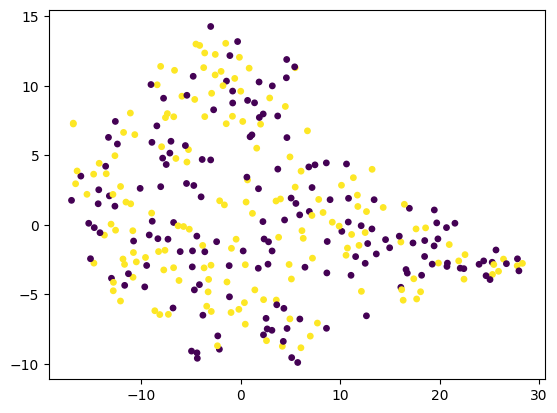

[Result of Random Forest]
Wavelet Transform Test Accuracy: 0.75


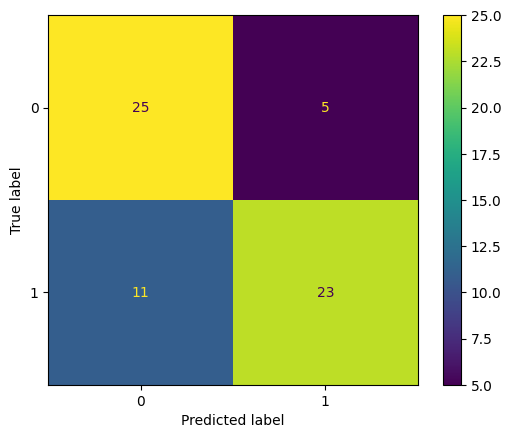

In [80]:
evaluate_feature(train_X_wav, train_y_wav, 'Wavelet Transform')

### Run with PCA

In [52]:
train_X_pca = pca_feature_matrix
train_y_pca = np.transpose(train_y)

[Result of t-SNE]


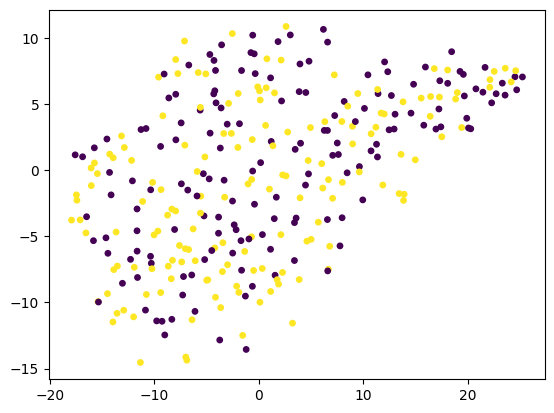

[Result of Random Forest]
PCA Test Accuracy: 0.67


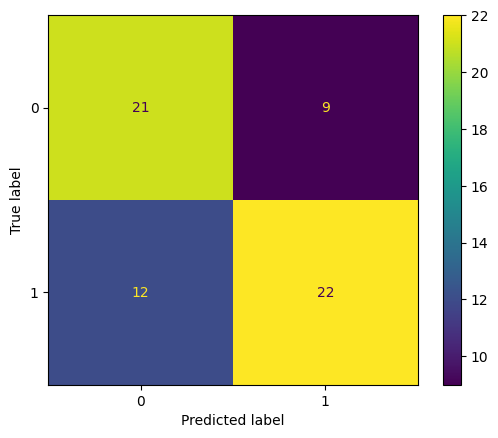

In [53]:
evaluate_feature(train_X_pca, train_y_pca, 'PCA')

### Run with ICA

In [54]:
train_X_ica = ica_feature_matrix
train_y_ica = np.transpose(train_y)

[Result of t-SNE]


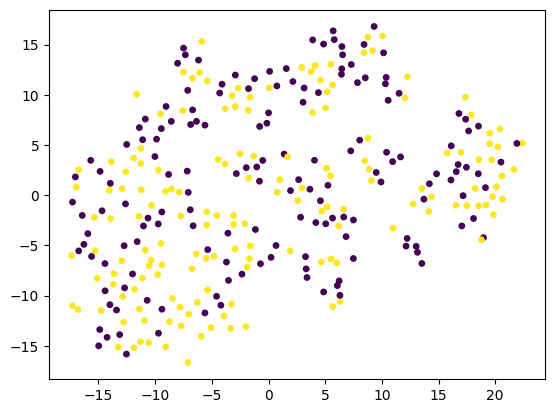

[Result of Random Forest]
ICA Test Accuracy: 0.58


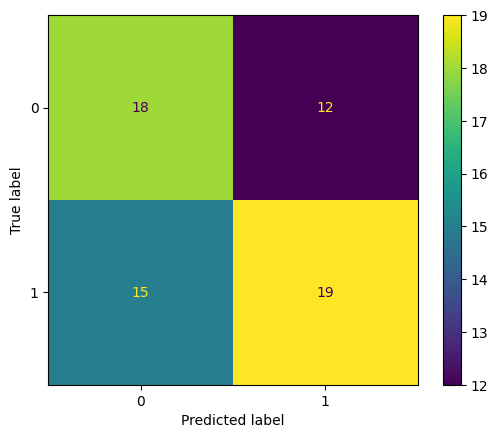

In [55]:
evaluate_feature(train_X_ica, train_y_ica, 'ICA')

### Run with SVD

In [56]:
train_X_svd = svd_feature_matrix
train_y_svd = np.transpose(train_y)

[Result of t-SNE]


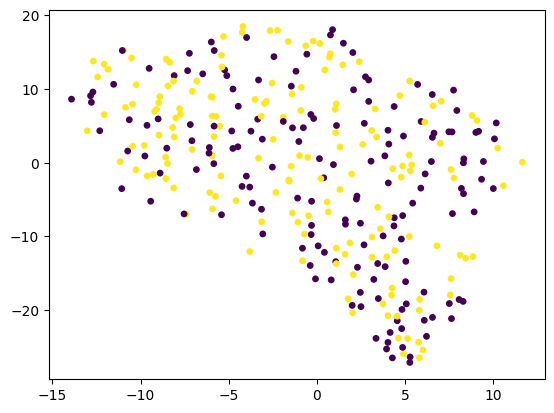

[Result of Random Forest]
SVD Test Accuracy: 0.70


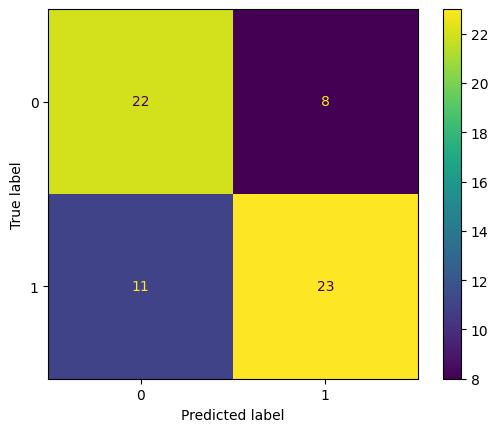

In [57]:
evaluate_feature(train_X_svd, train_y_svd, 'SVD')

### Run with PCA & ICA

In [58]:
train_X_PI = np.concatenate((pca_feature_matrix, ica_feature_matrix), axis=1)
train_y_PI = np.transpose(train_y)
train_X_PI.shape

(316, 52)

[Result of t-SNE]

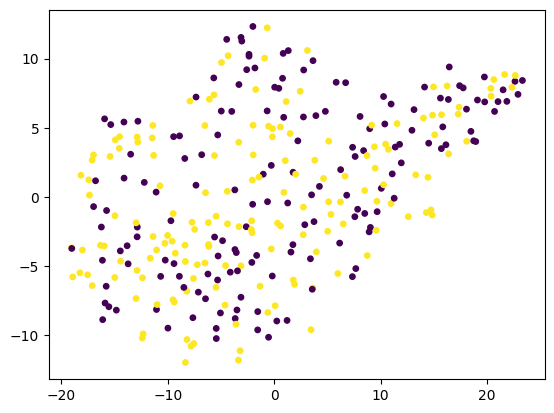

[Result of Random Forest]
PCA & ICA Test Accuracy: 0.66


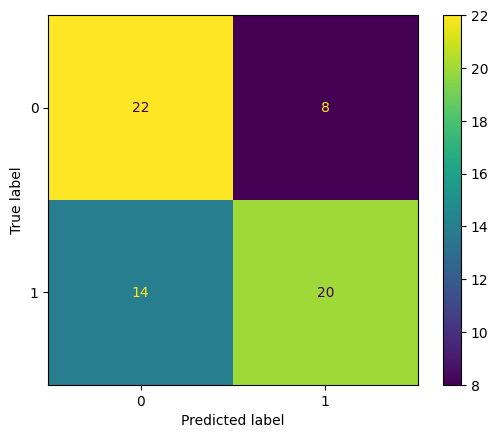

In [59]:
evaluate_feature(train_X_PI, train_y_PI, 'PCA & ICA')

### Run with CSP

In [60]:
train_X_csp = csp_feature_matrix
train_y_csp = np.transpose(train_y)

[Result of t-SNE]


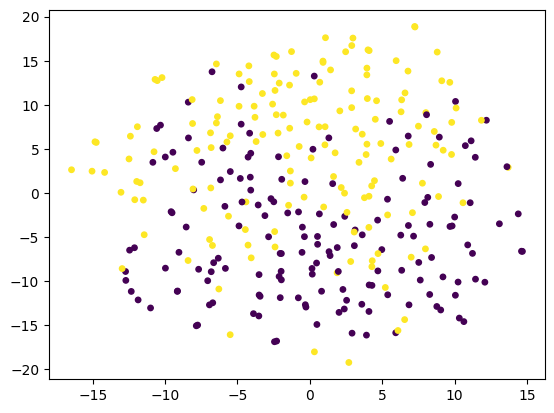

[Result of Random Forest]
CSP Test Accuracy: 0.84


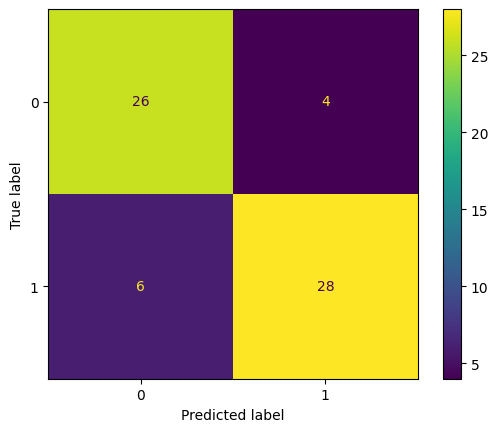

In [61]:
evaluate_feature(train_X_csp, train_y_csp, 'CSP')

### Run with Power Spectral Density
Delta, Alpha, Beta, Theta, Gamma

In [62]:
train_X_psd = psd_feature_matrix
train_y_psd = np.transpose(train_y)

[Result of t-SNE]


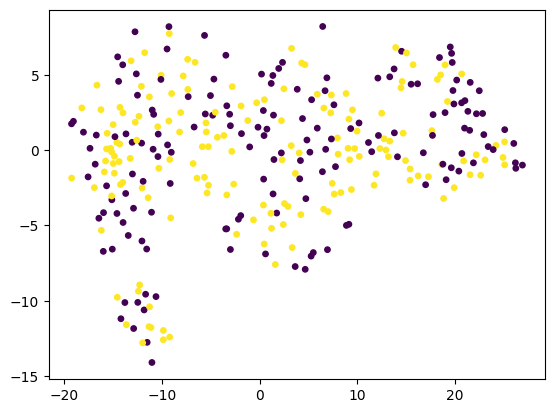

[Result of Random Forest]
PSD Test Accuracy: 0.77


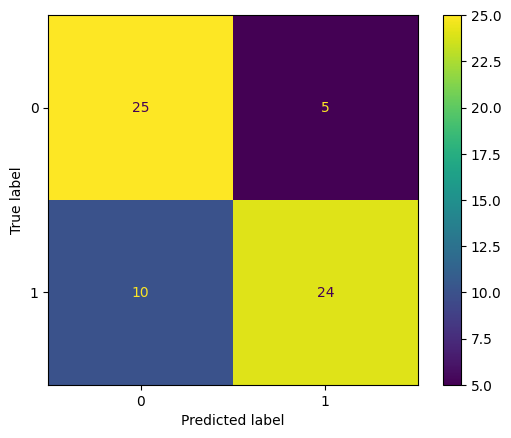

In [63]:
evaluate_feature(train_X_psd, train_y_psd, 'PSD')

### Run with Blind Source Separation

In [64]:
train_X_BS = np.concatenate((pca_feature_matrix, ica_feature_matrix, svd_feature_matrix, csp_feature_matrix), axis=1)
train_y_BS = np.transpose(train_y)
train_X_BS.shape

(316, 115)

[Result of t-SNE]


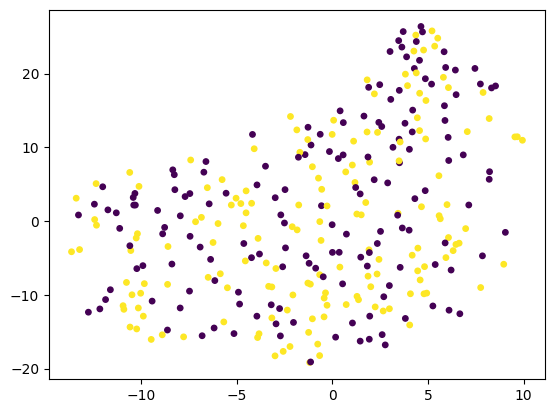

[Result of Random Forest]
Blind Source Separation Test Accuracy: 0.81


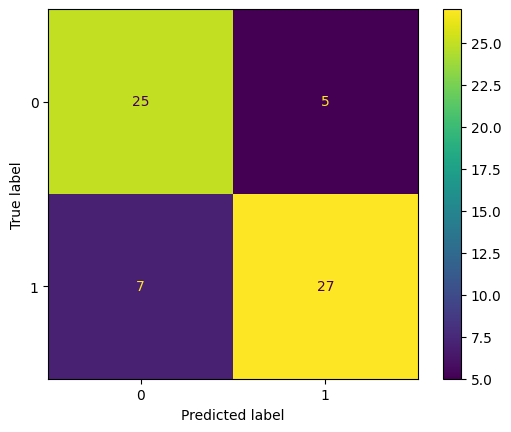

In [65]:
evaluate_feature(train_X_BS, train_y_BS, 'Blind Source Separation')

### Run with PSD & CSP

In [66]:
train_X_PC = np.concatenate((csp_feature_matrix, psd_feature_matrix), axis=1)
train_y_PC = np.transpose(train_y)
train_X_PC.shape

(316, 160)

[Result of t-SNE]


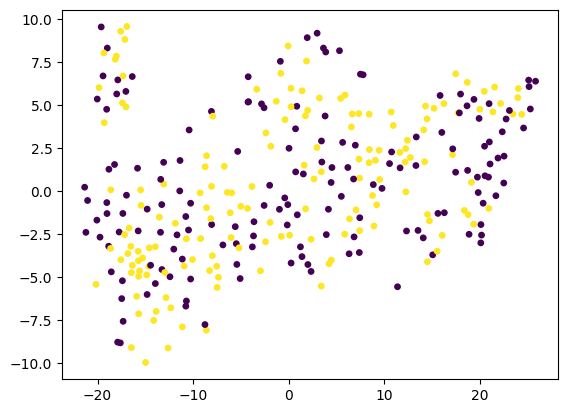

[Result of Random Forest]
PSD & CSP Test Accuracy: 0.81


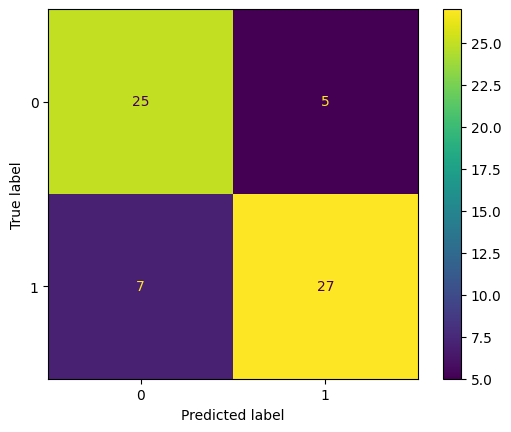

In [67]:
evaluate_feature(train_X_PC, train_y_PC, 'PSD & CSP')

In [68]:
## Validata the evaluation model(t-SNE, Random Forest)
# from sklearn import datasets

# # Data Load (MNIST: 64 dim)
# digits = datasets.load_digits()
# X = digits.data
# y = digits.target

# evaluate_with_tsne(X, y)
# evaluate_with_randomforest(X, y, 'MNIST')